# 10-1. Webサイトのアクセスログ解析

### 課題設定

```
あなたはとあるECサイトを運営している会社に新たに着任したデータサイエンティストです。
着任がてら上司から「現状の私たちのECサイトの状態を分析して状況を教えて欲しい、もし課題があれば解決策ももらえると嬉しいな。」と言われました。
また上司から「ちなみに私たちのKPIはCVR(商品購入数/商品詳細ページ閲覧数)だから、そのあたりを改善できると嬉しいかも」と追加の情報をもらいました。

どのように分析を進めて行けば良いでしょうか？
```

## 利用するデータ
- 講師がシミュレーションによって作成したある日のECサイトの行動ログ
- 以下のような列を持つ
  - timestamp ... タイムスタンプ（ログが生成された時間）
  - user_id ... ユーザーID
  - state_id ... ログ生成のタイプ(ID)
  - items ... 生成時に紐付くアイテムID
  - state_name ... ログ生成のタイプ(名前)

### Webサイトの構造（設定）

<img src="https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F108223%2F2b7ad3c4-db3a-9d83-4467-791c1d1433eb.png?ixlib=rb-1.2.2&auto=format&gif-q=60&q=75&w=1400&fit=max&s=42549123b92ee2d70a7ba174c2567c78">

In [1]:
# ライブラリの読み込み
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## データの理解

In [2]:
# とある1日のログデータのファイル
log_file = "https://raw.githubusercontent.com/rilmayer/data-science-lecture/master/data/20180629log.csv"

# 最初の行がタイムスタンプなので、データ型を指定する
df = pd.read_csv(log_file, dtype={0: str}, parse_dates =[0])

In [3]:
# ログ形式確認
df.head()

,timestamp,user_id,state_id,items,state_name
0,2018-06-29 09:00:02+09:00,80,0,NaN,top_page_view
1,2018-06-29 09:00:07+09:00,95,0,NaN,top_page_view
2,2018-06-29 09:00:07+09:00,7,0,NaN,top_page_view
3,2018-06-29 09:00:08+09:00,21,0,NaN,top_page_view
4,2018-06-29 09:00:09+09:00,17,0,NaN,top_page_view


In [4]:
# 一人のユーザーを追ってみる
df[df.user_id == 80].sort_values(by='timestamp').head(10)

,timestamp,user_id,state_id,items,state_name
0,2018-06-29 09:00:02+09:00,80,0,NaN,top_page_view
335,2018-06-29 09:30:17+09:00,80,0,NaN,top_page_view
337,2018-06-29 09:30:40+09:00,80,1,30:31:32:33:34:35:36:37:38:39,list_page_view
341,2018-06-29 09:31:27+09:00,80,0,NaN,top_page_view
359,2018-06-29 09:32:25+09:00,80,1,60:61:62:63:64:65:66:67:68:69,list_page_view
427,2018-06-29 09:34:19+09:00,80,2,63,detail_page_view
454,2018-06-29 09:34:53+09:00,80,1,60:61:62:63:64:65:66:67:68:69,list_page_view
524,2018-06-29 09:36:41+09:00,80,2,63,detail_page_view
583,2018-06-29 09:38:11+09:00,80,3,63,item_purchase
586,2018-06-29 09:38:12+09:00,80,0,NaN,top_page_view


## メジャーな指標を計算してみる
コースで触れたものの一部

- DAU (Daily Active Users) ... 日別のユーザー数
- CVR (Conversion Rate) ... ユーザーあたりのコンバージョン(重要なアクション)数
- CTR (Click Through Rate) ... とあるページからとあるページへ遷移した数の割合
- PV (Page View) ... とあるページのアクセス数


In [5]:
# DAUを求める
n_users = len(df.user_id.unique())
n_users

100

In [6]:
# CVRの計算
n_detail_page_viewl = df[df.state_name == 'detail_page_view'].shape[0]
n_item_purchase = df[df.state_name == 'item_purchase'].shape[0]
n_item_purchase / n_detail_page_viewl

0.20068359375

In [7]:
# CTRの計算 (# of detail_page_viewl/ # of ist_page_view)
n_detail_page_viewl = df[df.state_name == 'detail_page_view'].shape[0]
n_list_page_view = df[df.state_name == 'list_page_view'].shape[0]
n_detail_page_viewl / n_list_page_view

0.5055541841520612

In [8]:
# 各ページのPV
print("n_item_purchase", n_item_purchase)
print("n_detail_page_viewl: ", n_detail_page_viewl)
print("n_list_page_view: ", n_list_page_view)

n_item_purchase 411
n_detail_page_viewl:  2048
n_list_page_view:  4051


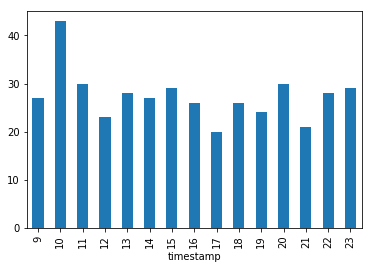

In [9]:
# 時間帯別購入回数
tmp_df = df[df.state_name == 'item_purchase']
tmp_df.groupby(tmp_df.timestamp.dt.hour).count().user_id.plot(kind='bar')

## 課題の分析
通常はなんらかの軸（ディメンション）によって分けてみるところからスタートする

### 商品別のCVRを分析

In [10]:
# 商品ごとのCVRをみてみる
#   この「商品ごと」という切り口は分析者の仮説構築力や発想力に基づく
viewed_items = df[df.state_name == 'detail_page_view']['items'].value_counts()
purchased_items = df[df.state_name == 'item_purchase']['items'].value_counts()
item_cvr_df = pd.DataFrame(purchased_items / viewed_items)

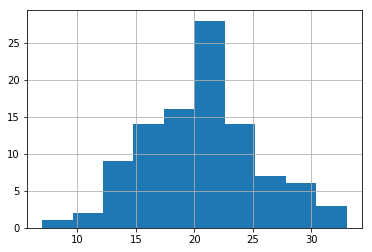

In [11]:
# 商品閲覧数の分布を確認
viewed_items.hist()

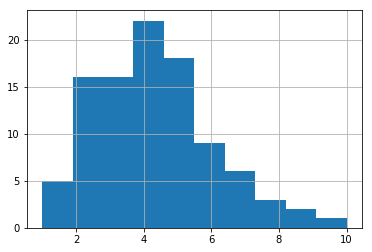

In [12]:
# 購入数の分布を確認
purchased_items.hist()

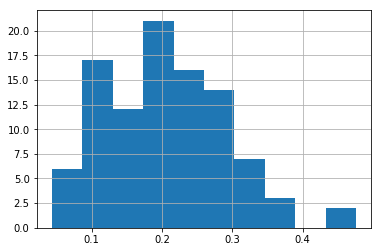

In [13]:
# CVRの分布を確認
item_cvr_df['items'].hist()

In [14]:
# CVRの高い商品
item_cvr_df.sort_values(by='items', ascending=False).head()

,items
55,0.476190
85,0.444444
60,0.384615
4,0.352941
59,0.350000


In [15]:
# これらの商品はどのくらい見られているのか？（閲覧数が少なくはないか確認）
viewed_items['55'], viewed_items['85']

(21, 18)

### ユーザーセグメントを作って分析

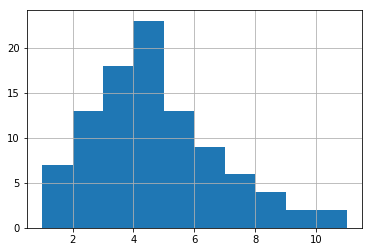

In [16]:
# ユーザーごとの購入数をみてみる
df[df.state_name == 'item_purchase'].user_id.value_counts().hist()

In [17]:
# へービーユーザーとライトユーザーを、6回以上の購入で分ける
#   ヘビーユーザーとライトユーザーで行動が異なるのではないかという仮説
n_user_purchased_df = pd.DataFrame(df[df.state_name == 'item_purchase'].user_id.value_counts())
n_user_purchased_df = n_user_purchased_df.reset_index()
n_user_purchased_df.columns = ['user_id', 'n_purchased']
merged_df = pd.merge(df, n_user_purchased_df, on='user_id', how='left')
merged_df['user_segment'] = merged_df.n_purchased.apply(lambda x: 'heavy' if x >= 6 else 'light')

In [18]:
# ヘビーユーザーとライトユーザーの数
merged_df['user_segment'].value_counts()

light    7878
heavy    2844
Name: user_segment, dtype: int64

In [19]:
merged_df.head()

,timestamp,user_id,state_id,items,state_name,n_purchased,user_segment
0,2018-06-29 09:00:02+09:00,80,0,NaN,top_page_view,8.0,heavy
1,2018-06-29 09:00:07+09:00,95,0,NaN,top_page_view,7.0,heavy
2,2018-06-29 09:00:07+09:00,7,0,NaN,top_page_view,4.0,light
3,2018-06-29 09:00:08+09:00,21,0,NaN,top_page_view,6.0,heavy
4,2018-06-29 09:00:09+09:00,17,0,NaN,top_page_view,6.0,heavy


In [20]:
# ヘビーユーザーとライトユーザーで人気な商品に違いはあるか？
#[['user_segment', 'items', 'timestamp']].groupby('user_segment').count()
purchased_df = merged_df[merged_df.state_name == 'item_purchase']
segmented_purchased_df = pd.crosstab(purchased_df['user_segment'], purchased_df['items'], normalize='index').T

In [21]:
# ライトユーザーの方がよく売れている商品
segmented_purchased_df['ratio'] =  segmented_purchased_df.light / segmented_purchased_df.heavy
segmented_purchased_df[segmented_purchased_df.heavy != 0].sort_values(by='ratio', ascending=False).head()

user_segment,heavy,light,ratio
items,,,
94,0.005988,0.020492,3.422131
80,0.005988,0.016393,2.737705
10,0.005988,0.016393,2.737705
55,0.011976,0.032787,2.737705
9,0.005988,0.016393,2.737705


In [22]:
# ヘビーユーザーの方がよく売れている商品
segmented_purchased_df['ratio'] =  segmented_purchased_df.heavy / segmented_purchased_df.light
segmented_purchased_df[segmented_purchased_df.light != 0].sort_values(by='ratio', ascending=False).head()

user_segment,heavy,light,ratio
items,,,
92,0.023952,0.004098,5.844311
83,0.023952,0.004098,5.844311
99,0.017964,0.004098,4.383234
74,0.029940,0.008197,3.652695
30,0.011976,0.004098,2.922156


## ここまでで分かったことをまとめる

### Webサイトの主要指標
- DAU ... 100
- CVR ... 0.20068359375
- CTR ... 0.5055541841520612
- PV
  - n_item_purchase 411
  - n_detail_page_viewl:  2048
  - n_list_page_view:  4051
  
（上記のデータを用いて以下のようなファネル図を作るのも効果的、数値はてきとう）


<img src="https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F108223%2F17836200-0608-7aa0-ae68-20e63ef27ca2.png?ixlib=rb-1.2.2&auto=format&gif-q=60&q=75&s=0422d2139365dcba4ee24b1cc9ba9b30">

### 商品別の分析
- CVRが非常に高い商品群がある
- 施策案：広告などの費用対効果が高いと考えられ、これらの商品を元にマーケティング施策を打つのは効果的かもしれない

### ユーザーセグメント別の分析
- よく商品を購入しているユーザー(n>5)と、あまり商品を購入していないユーザーに分けて分析したところ、購入商品の傾向の違いがみられた
- 施策案：ライトユーザー向けとヘビーユーザー向けの商品を分けて推薦すると効果的かもしれない

# 大事な注意
- ここまで分析してきた内容はそもそもがシミュレーションに基づいてランダムにデータを生成したもの
- つまり上記で得られた傾向は全て「偶然の結果」と言える
- 現実のデータ分析では、**偶然にも関わらず**、それを説明付けるもっともらしい仮説が考えられることがある
- 上記はシミュレーションデータによる分析ではあるが、実際のデータ分析では「商品の性質」や「ユーザーの性質」、「Webサイトの性質」、「世の中の状態」など様々な変数を考慮して分析を進める必要があることを常に注意して欲しい